<a href="https://colab.research.google.com/github/BYU-Hydroinformatics/baseflow-notebooks/blob/main/baseflow_separation_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Welcome to the Baseflow Separation Google Colab Notebook. This notebook demonstrates the available functions and how to use them.**

# **Instructions**

This is a Google Colab Notebook shared via Github. You can run operations within this notebook and see the results directly. Note that changes will not be saved if you refresh this page. To save a copy of this notebook, click on the File tab and then select "Save a copy in Drive."

To execute each cell, press the play button on the left side of the cell. If you encounter an error, double-check that all input options are correct.

For more detailed documentation, please visit our help function or documentation page. https://baseflow.readthedocs.io/en/latest/

# Install baseflow package from github

In [ ]:
!pip install git+https://github.com/BYU-Hydroinformatics/baseflow.git

  Cloning https://github.com/BYU-Hydroinformatics/baseflow.git (to revision merge-my-changes) to /tmp/pip-req-build-y_pnoom9
  Running command git clone --filter=blob:none --quiet https://github.com/BYU-Hydroinformatics/baseflow.git /tmp/pip-req-build-y_pnoom9
  Running command git checkout -b merge-my-changes --track origin/merge-my-changes
  Switched to a new branch 'merge-my-changes'
  Branch 'merge-my-changes' set up to track remote branch 'merge-my-changes' from 'origin'.
  Resolved https://github.com/BYU-Hydroinformatics/baseflow.git to commit d9299a98b98208a1eb9d180297c8adc18bc64af5
  Preparing metadata (setup.py) ... done
  Created wheel for baseflow: filename=baseflow-0.0.9-py3-none-any.whl size=100129 sha256=61747dfa0ec7da3372edb61972998971652ae427f4bb4e22d1d37a34678a25f0
  Stored in directory: /tmp/pip-ephem-wheel-cache-ejjrfiga/wheels/0e/ca/9c/e2259c62c945f009aa7c4476e99f87b76acf6fa6ece50be949
Successfully built baseflow


## Load necessary packages

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go

# Separation methods

In [ ]:
import baseflow
import baseflow.separation

In [ ]:
help(baseflow.separation)

Help on module baseflow.separation in baseflow:

NAME
    baseflow.separation

FUNCTIONS
    boughton(Q, a, C, initial_method='Q0', return_exceed=False)
        Boughton doulbe-parameter filter (Boughton, 2004)
        Boughton W.C. (1993) - A hydrograph-based model for estimating water yield of ungauged catchments. Institute of Engineers Australia National Conference. Publ. 93/14, pp. 317-324.
        
        Args:
            Q (np.array): streamflow
            a (float): recession coefficient
            C (float): calibrated in baseflow.param_estimate
            initial_method (str or float, optional): method to calculate the initial baseflow value.
                Accepted string values are:
                - 'Q0': Use Q[0] as the initial baseflow value.
                - 'min': Use np.min(Q) as the initial baseflow value.
                - 'LH': Calculate the initial baseflow value using the LH method.
                Alternatively, a float value can be provided to directly se

### Create a plotting function for comparison

In [ ]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_baseflow_separation(Q, baseflows, method_names=None, interactive=False):
    if method_names is None:
        method_names = list(baseflows.keys())

    if interactive:
        fig = make_subplots()
        fig.add_trace(go.Scatter(x=Q.index, y=Q.values, name='Streamflow', line=dict(width=2)))

        for method in method_names:
            if method in baseflows:
                fig.add_trace(go.Scatter(x=Q.index, y=baseflows[method], name=f'{method} Baseflow'))

        fig.update_layout(
            title='Baseflow Separation',
            xaxis_title='Date',
            yaxis_title='Flow',
            legend_title='Methods',
            hovermode="x unified",
            width=1100,
            height=600
        )

        return fig
    else:
        plt.figure(figsize=(12, 6))
        plt.plot(Q.index, Q.values, label='Observed Streamflow', alpha=0.7)

        for method in method_names:
            if method in baseflows:
                plt.plot(Q.index, baseflows[method], label=f'{method} Baseflow', alpha=0.7)

        plt.xlabel('Date')
        plt.ylabel('Flow')
        plt.title('Baseflow Separation')
        plt.legend()
        plt.grid(True)

        return plt.gcf()

In [ ]:
# examples
# baseflows = {
#     'Fixed': bf_fixed['Fixed'],
#     'Slide': bf_slide['Slide'],
# }

# # Matplotlib
# fig = plot_baseflow_separation(Q, baseflows, ['Fixed', 'Slide'], interactive=False)
# plt.show()

# # Plotly
# fig = plot_baseflow_separation(Q, baseflows, ['Fixed', 'Slide'], interactive=True)
# fig.show()

### Load example Q data

In [ ]:
df = pd.read_csv(baseflow.example, index_col=0, parse_dates=True)
Q = df[df.columns[0]]
Q

time
2001-01-01     4.089
2001-01-02     6.633
2001-01-03     6.530
2001-01-04     4.725
2001-01-05     4.242
               ...  
2010-12-27     1.781
2010-12-28     1.338
2010-12-29     6.804
2010-12-30     4.191
2010-12-31    42.535
Name: GRDC_1160815, Length: 3652, dtype: float64

## Cleaning data

In [ ]:
import baseflow.utils

In [ ]:
Q = baseflow.utils.clean_streamflow(Q)
Q

In [ ]:
# calculate LH outcome for input
b_LH = baseflow.separation.lh(Q.values,beta=0.925, return_exceed=False)

## **1. Graphic methods**
The graphic methods estimate baseflow by connecting specific low-flow points of a streamflow hydrograph.

### 1.1 UKIH
This method, developed by the UK Institute of Hydrology, uses a fixed-interval smoothing algorithm to separate baseflow from streamflow, emphasizing longer-term trends in the hydrograph.

In [ ]:
help(baseflow.separation.ukih)

Help on function ukih in module baseflow.separation:

ukih(Q, b_LH, return_exceed=False)
    graphical method developed by UK Institute of Hydrology (UKIH, 1980)
    Aksoy, Hafzullah, Ilker Kurt, and Ebru Eris. “Filtered Smoothed Minima Baseflow Separation Method.” Journal of Hydrology 372, no. 1 (June 15, 2009): 94–101. https://doi.org/10.1016/j.jhydrol.2009.03.037.
    
    Args:
        Q (np.array): streamflow
        return_exceed (bool, optional): if True, returns the number of times the
            baseflow exceeds the streamflow.



In [ ]:
bf_ukih = {
    'UKIH': baseflow.separation.ukih(Q.values, b_LH, return_exceed=False),
}

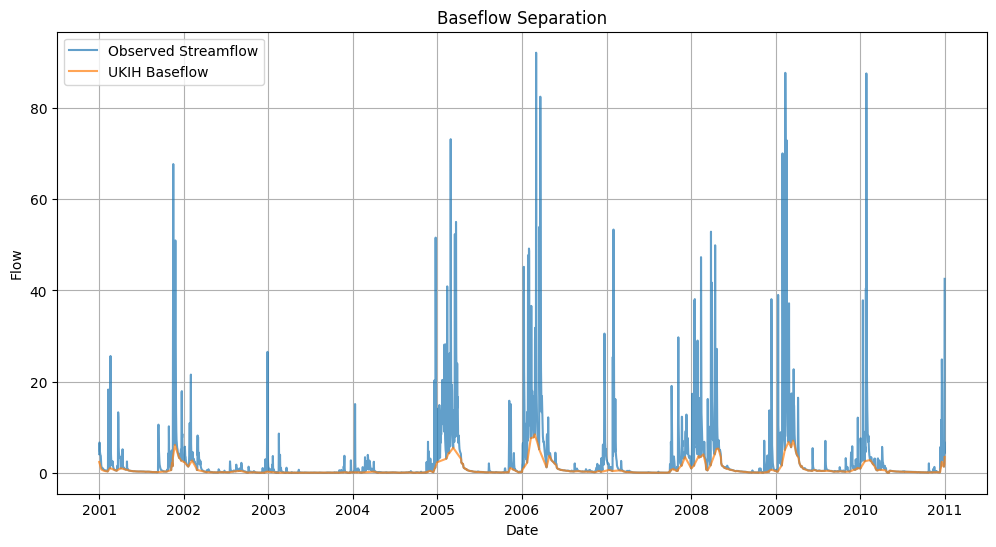

In [ ]:
baseflows = {
    'UKIH': bf_ukih['UKIH'],
}
plot_baseflow_separation(Q, bf_ukih, ['UKIH'], interactive=False)
plt.show()

### 1.2 HYSEP

#### Local minimum
The low points of the streamflow hydrograph are determined using a moving interval or sliding window of specified width (i.e. equal to a set number of streamflow readings in the source dataset). Each streamflow value is checked whether it is the lowest in a given interval or not. If it is, then it is considered a local minimum and is joined with adjacent local minimums using a straight line. The resulting line, across the whole dataset, represents the baseflow hydrograph.

In [ ]:
help(baseflow.separation.local)

Help on function local in module baseflow.separation:

local(Q, b_LH, area=None, return_exceed=False)
    Local minimum graphical method from HYSEP program (Sloto & Crouse, 1996)
    
    Args:
        Q (np.array): streamflow
        area (float): basin area in km^2



In [ ]:
bf_local = {
    'Local': baseflow.separation.local(Q.values, b_LH, area=None, return_exceed=False),
}

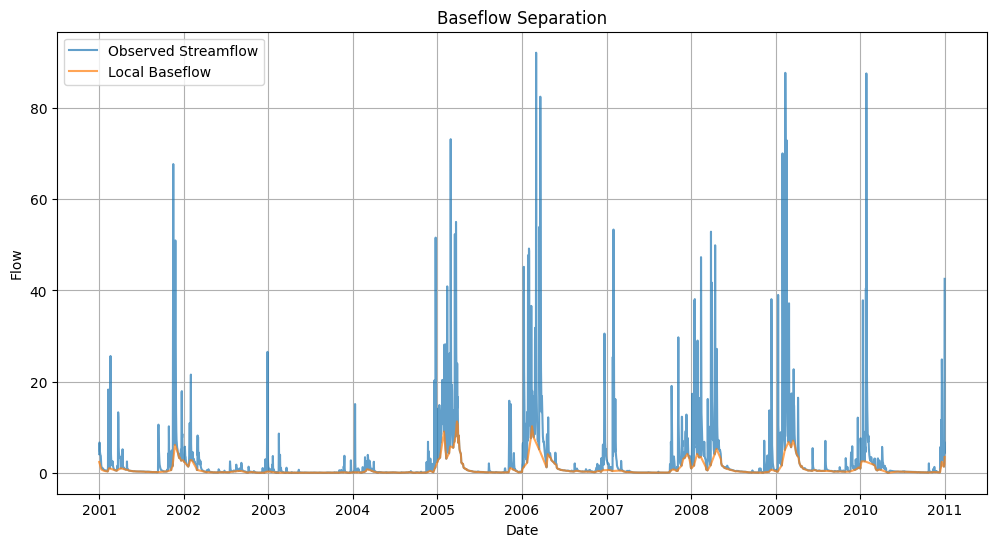

In [ ]:
baseflows = {
    'Local' : bf_local['Local'],
}
plot_baseflow_separation(Q, bf_local, ['Local'], interactive=False)
plt.show()

#### Fixed interval
The method systematically draws connecting lines between the low points of the streamflow hydrograph to determine the baseflow hydrograph. The low points of the streamflow hydrograph are determined using a fixed window of specified width (i.e. equal to a set number of streamflow readings in the source dataset).


All baseflow values in a given interval or window are set to the minimum streamflow value in that respective interval.

In [ ]:
help(baseflow.separation.fixed)

Help on function fixed in module baseflow.separation:

fixed(Q, area=None)
    Fixed interval graphical method from HYSEP program (Sloto & Crouse, 1996)
    Sloto, R. A., & Crouse, M. Y. (1996). HYSEP: A Computer Program for Streamflow Hydrograph Separation and Analysis (96-4040). Reston, VA: U.S. Geological Survey. https://doi.org/10.3133/wri964040.
    
    Args:
        Q (np.array): streamflow
        area (float): basin area in km^2



In [ ]:
bf_fixed = {
    'Fixed': baseflow.separation.fixed(Q.values,area = None),
}


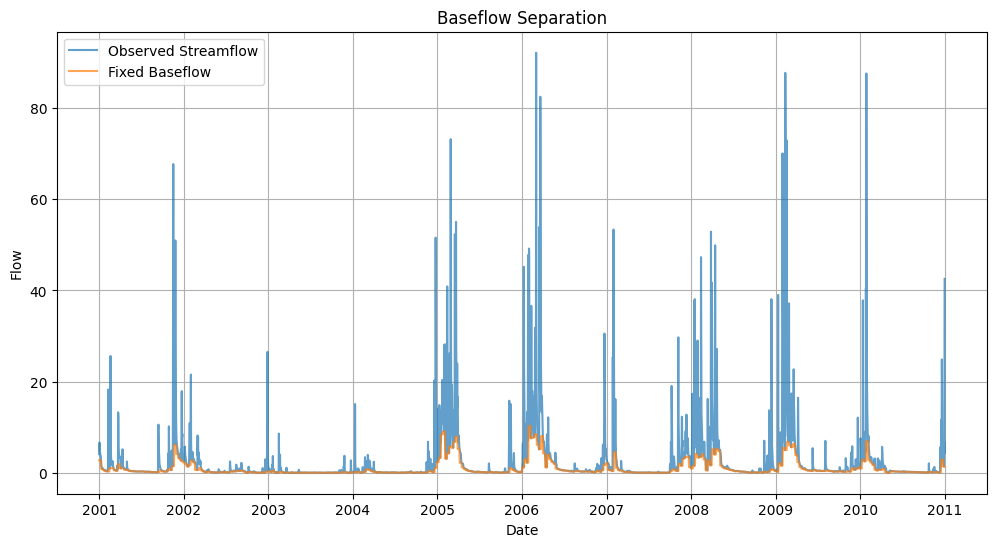

In [ ]:
plot_baseflow_separation(Q, bf_fixed, ['Fixed'], interactive=False)
plt.show()

#### Sliding interval
The low points of the streamflow hydrograph are determined using a moving interval or sliding window of specified width (i.e. equal to a set number of streamflow readings in the source dataset). The baseflow value in the middle of each given interval or window is set to the minimum streamflow value in that respective interval.

In [ ]:
help(baseflow.separation.slide)

Help on function slide in module baseflow.separation:

slide(Q, area)
    Slide interval graphical method from HYSEP program (Sloto & Crouse, 1996)
    Sloto, R. A., & Crouse, M. Y. (1996). HYSEP: A Computer Program for Streamflow Hydrograph Separation and Analysis (96-4040). Reston, VA: U.S. Geological Survey. https://doi.org/10.3133/wri964040.
    
    Args:
        Q (np.array): streamflow
        area (float): basin area in km^2



In [ ]:
bf_slide = {
    'Slide': baseflow.separation.slide(Q, area = None),
}

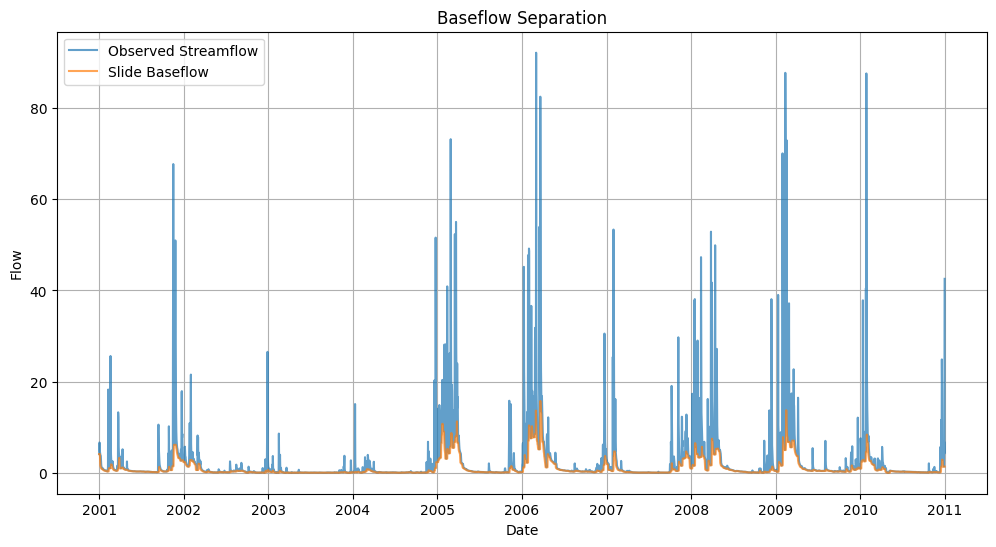

In [ ]:
plot_baseflow_separation(Q, bf_slide, ['Slide'], interactive=False)
plt.show()

## **2. Digital filter methods**
The digital filter methods estimate baseflow by signal analysis with the assumption that baseflow is the low-frequency part of streamflow.

### 2.1 Lyne Hollick
This hydrograph separation method was first introduced by Lyne and Hollick in 1979. It has been designed as a means of analyzing the time-dependent and slow stream responses to precipitation. The method assumes high frequency signals to represent direct runoff, while low frequency signals are associated with the baseflow component. The method calculates the surface runoff component which, together with the streamflow, is then used to derive the baseflow component.

**For the Lyne-Hollick method, this equation is executed in two passes, including a forward pass and a backward pass. The number of passes can be adjusted in the subsequent function.**

In [ ]:
help(baseflow.separation.lh)

Help on function lh in module baseflow.separation:

lh(Q, beta=0.925, return_exceed=False)
    LH digital filter (Lyne & Hollick, 1979)
    Lyne, V. and Hollick, M. (1979) Stochastic Time-Variable Rainfall-Runoff Modeling. Institute of Engineers Australia National Conference, 89-93.
    
    Args:
        Q (np.array): streamflow
        beta (float): filter parameter, 0.925 recommended by (Nathan & McMahon, 1990)



In [ ]:
bf_lh = {
    'Lyne Hollick': baseflow.separation.lh(Q.values,beta=0.925, return_exceed=False),
}

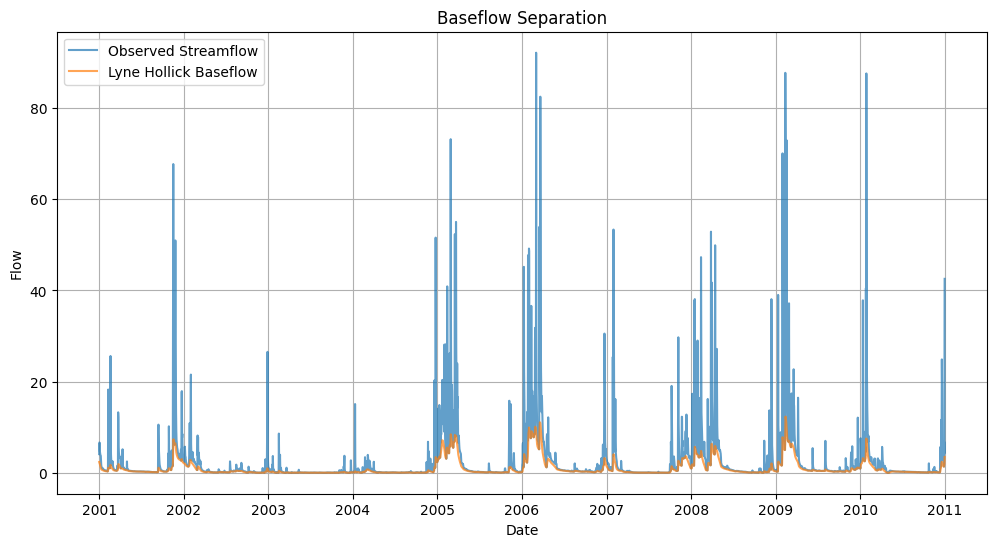

In [ ]:
plot_baseflow_separation(Q, bf_lh, ['Lyne Hollick'], interactive=False)
plt.show()

#### optional pass numbers

Different passes are used in the Lyne-Hollick method to improve the accuracy of baseflow separation. The forward pass filters the streamflow data to remove high-frequency components associated with direct runoff. The backward pass then refines this by further smoothing the data, helping to ensure that the baseflow estimate is more accurate and consistent over time. By adjusting the number of passes, the method can better adapt to varying hydrological conditions and provide a more reliable separation of baseflow from total streamflow.

In [ ]:
help(baseflow.separation.lh_multi)

Help on function lh_multi in module baseflow.separation:

lh_multi(Q, beta=0.925, num_pass=2, return_exceed=False)
    Applies a low-pass filter to the input time series `Q` using the Lyne-Hollick (LH) recursive digital filter.
    
    The filter is applied in multiple passes, with the number of passes controlled by the `num_pass` parameter. The filter uses a smoothing parameter `beta` to control the degree of filtering.
    
    Spongberg, M. E. “Spectral Analysis of Base Flow Separation with Digital Filters.” Water Resources Research 36, no. 3 (2000): 745–52. https://doi.org/10.1029/1999WR900303.
    
    If `return_exceed` is True, the function will also return the number of times the filtered output `b` exceeds the original input `Q`.
    
    Lyne, V. and Hollick, M. (1979) Stochastic Time-Variable Rainfall-Runoff Modeling. Institute of Engineers Australia National Conference, 89-93. 
    
    Spongberg, M. E. “Spectral Analysis of Base Flow Separation with Digital Filters.” Wate

In [ ]:
bf_lh_multi = {
    'Lyne Hollic (3 passes)': baseflow.separation.lh_multi(Q.values,beta=0.925, num_pass=3, return_exceed=False),
}

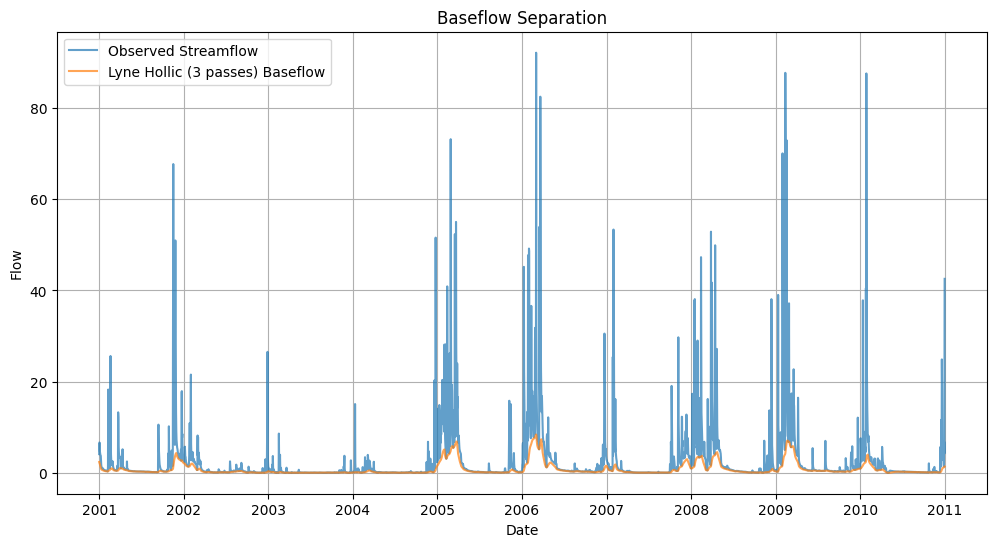

In [ ]:
plot_baseflow_separation(Q, bf_lh_multi, ['Lyne Hollic (3 passes)'], interactive=False)
plt.show()

### 2.2 Chapman
The Chapman method was introduced in 1991 as a response to Lyne-Hollick algorithm's results, which incorrectly provided a constant streamflow or baseflow even when direct runoff has ceased.

We provide four methods for calculating the initial baseflow value. Users are free to choose among these options. For more details, please refer to the help function.

In [ ]:
help(baseflow.separation.chapman)

Help on function chapman in module baseflow.separation:

chapman(Q, a, initial_method='Q0', return_exceed=False)
    Chapman filter (Chapman, 1991)
    Chapman, Tom G. "Comment on 'Evaluation of Automated Techniques for Base Flow and Recession Analyses' by R. J. Nathan and T. A. McMahon." Water Resources Research 27, no. 7 (1991): 1783–84. https://doi.org/10.1029/91WR01007.
    
    Args:
        Q (np.array): streamflow
        a (float): recession coefficient
        initial_method (str or float, optional): method to calculate the initial baseflow value.
            Accepted string values are:
            - 'Q0': Use Q[0] as the initial baseflow value.
            - 'min': Use np.min(Q) as the initial baseflow value.
            - 'LH': Calculate the initial baseflow value using the LH method.
            Alternatively, a float value can be provided to directly set the initial baseflow value.
            Default is 'Q0'.
        return_exceed (bool, optional): if True, returns the nu

In [ ]:
a = 0.98  # Assumed recession coefficient

bf_chapman = {
    'Chapman': baseflow.separation.chapman(Q.values, a, initial_method='Q0',return_exceed=False),
}

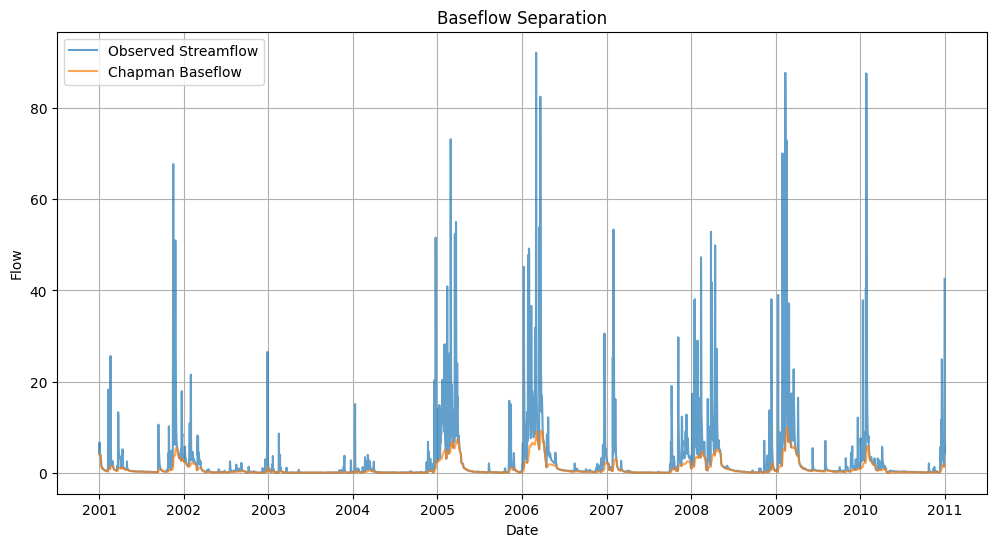

In [ ]:
plot_baseflow_separation(Q, bf_chapman, ['Chapman'], interactive=False)
plt.show()

### 2.3 Chapman & Maxwell
The Chapman and Maxwell hydrograph separation digital filter, introduced in 1996, can be viewed as a simplified version of the Boughton filter from 1993.

We provide four methods for calculating the initial baseflow value. Users are free to choose among these options. For more details, please refer to the help function.

In [ ]:
help(baseflow.separation.chapman_maxwell)

Help on function chapman_maxwell in module baseflow.separation:

chapman_maxwell(Q, a, initial_method='Q0', return_exceed=False)
    CM filter (Chapman & Maxwell, 1996)
    Chapman, T. G., Maxwell, A. I. (1996) - Baseflow separation - comparison of numerical methods with tracer experiments, in Hydrol. and Water Resour. Symp., Institution of Engineers Australia, Hobart. pp. 539-545.
    
    Args:
        Q (np.array): streamflow
        a (float): recession coefficient
        initial_method (str or float, optional): method to calculate the initial baseflow value.
            Accepted string values are:
            - 'Q0': Use Q[0] as the initial baseflow value.
            - 'min': Use np.min(Q) as the initial baseflow value.
            - 'LH': Calculate the initial baseflow value using the LH method.
            Alternatively, a float value can be oythoprovided to directly set the initial baseflow value.
            Default is 'Q0'.



In [ ]:
bf_cm = {
    'Chapman & Maxwell': baseflow.separation.chapman(Q.values, a, initial_method='Q0',return_exceed=False),
}

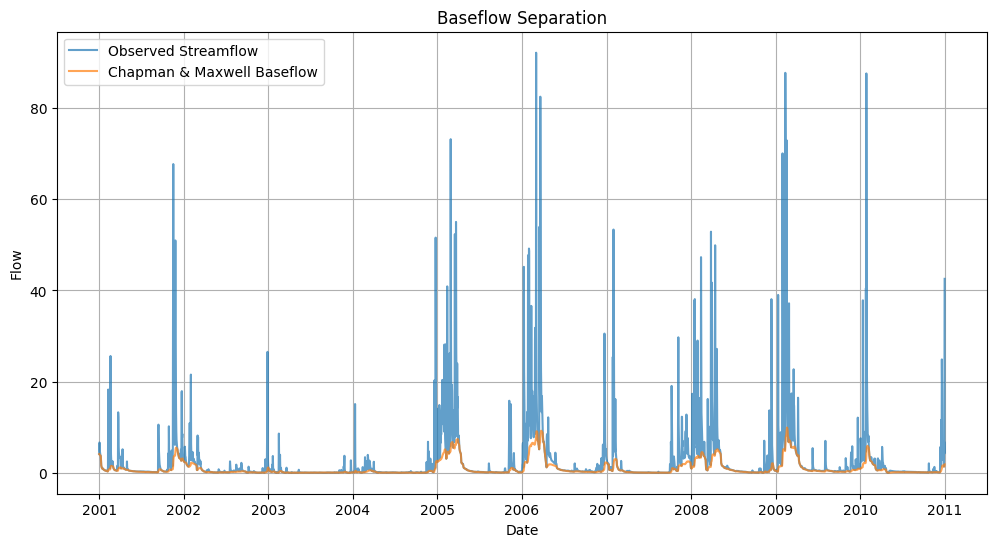

In [ ]:
plot_baseflow_separation(Q, bf_cm, ['Chapman & Maxwell'], interactive=False)
plt.show()

### 2.4 Boughton

Developed by Walter Boughton in 1993, together with the widespread AWBM rainfall-runoff model. The method is using groundwater levels for hydrograph separation and essentially works as a one-pass filter.

We provide four methods for calculating the initial baseflow value. Users are free to choose among these options. For more details, please refer to the help function.

In [ ]:
help(baseflow.separation.boughton)

Help on function boughton in module baseflow.separation:

boughton(Q, a, C, initial_method='Q0', return_exceed=False)
    Boughton doulbe-parameter filter (Boughton, 2004)
    Boughton W.C. (1993) - A hydrograph-based model for estimating water yield of ungauged catchments. Institute of Engineers Australia National Conference. Publ. 93/14, pp. 317-324.
    
    Args:
        Q (np.array): streamflow
        a (float): recession coefficient
        C (float): calibrated in baseflow.param_estimate
        initial_method (str or float, optional): method to calculate the initial baseflow value.
            Accepted string values are:
            - 'Q0': Use Q[0] as the initial baseflow value.
            - 'min': Use np.min(Q) as the initial baseflow value.
            - 'LH': Calculate the initial baseflow value using the LH method.
            Alternatively, a float value can be provided to directly set the initial baseflow value.
            Default is 'Q0'.
        return_exceed (bool,

In [ ]:
a = 0.98  # Assumed recession coefficient
C = 0.1   # Assumed parameter C

bf_boughton = {
    'Boughton': baseflow.separation.boughton(Q.values, a, C, initial_method='Q0',return_exceed=False),
}


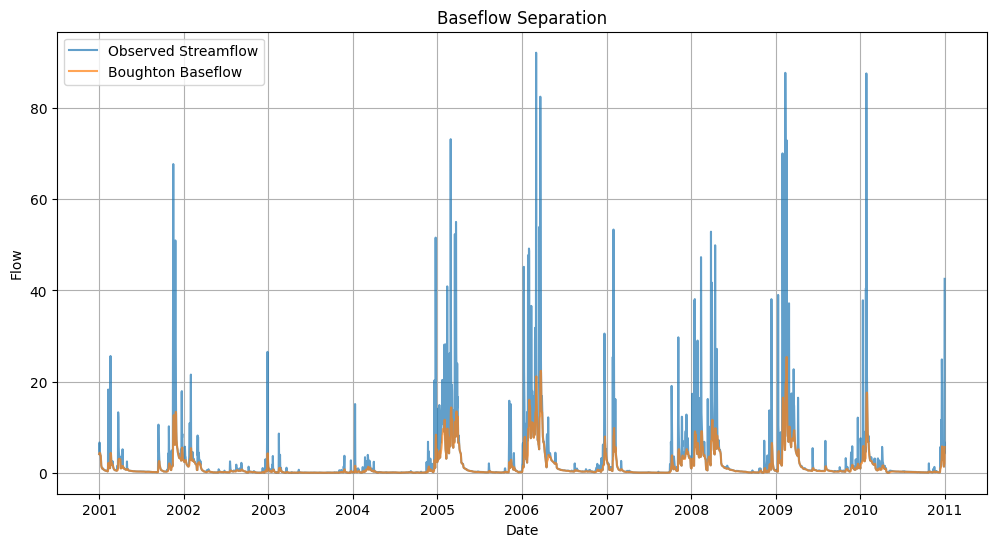

In [ ]:
plot_baseflow_separation(Q, bf_boughton, ['Boughton'], interactive=False)
plt.show()

### 2.5 Eckhardt
In 2004, Eckhardt presented a new two-parameter algorithm for hydrograph separation that was inspired by the previous one-parameter filters.

We provide four methods for calculating the initial baseflow value. Users are free to choose among these options. For more details, please refer to the help function.

In [ ]:
help(baseflow.separation.eckhardt)

Help on function eckhardt in module baseflow.separation:

eckhardt(Q, a, BFImax, initial_method='Q0', return_exceed=False)
    Eckhardt filter (Eckhardt, 2005)
    Eckhardt, K. “How to Construct Recursive Digital Filters for Baseflow Separation.” Hydrological Processes 19, no. 2 (2005): 507–15. https://doi.org/10.1002/hyp.5675.
    
    Args:
        Q (np.array): streamflow
        a (float): recession coefficient
        BFImax (float): maximum value of baseflow index (BFI)
        initial_method (str or float, optional): method to calculate the initial baseflow value.
            Accepted string values are:
            - 'Q0': Use Q[0] as the initial baseflow value.
            - 'min': Use np.min(Q) as the initial baseflow value.
            - 'LH': Calculate the initial baseflow value using the LH method.
            Alternatively, a float value can be provided to directly set the initial baseflow value.
            Default is 'Q0'.
        return_exceed (bool, optional): if True,

In [ ]:
a = 0.98  # Assumed recession coefficient
BFImax = 0.8  # Assumed parameter BFImax

bf_eckhardt = {
    'Eckhardt': baseflow.separation.eckhardt(Q.values, a, BFImax, initial_method='Q0', return_exceed=False),
}


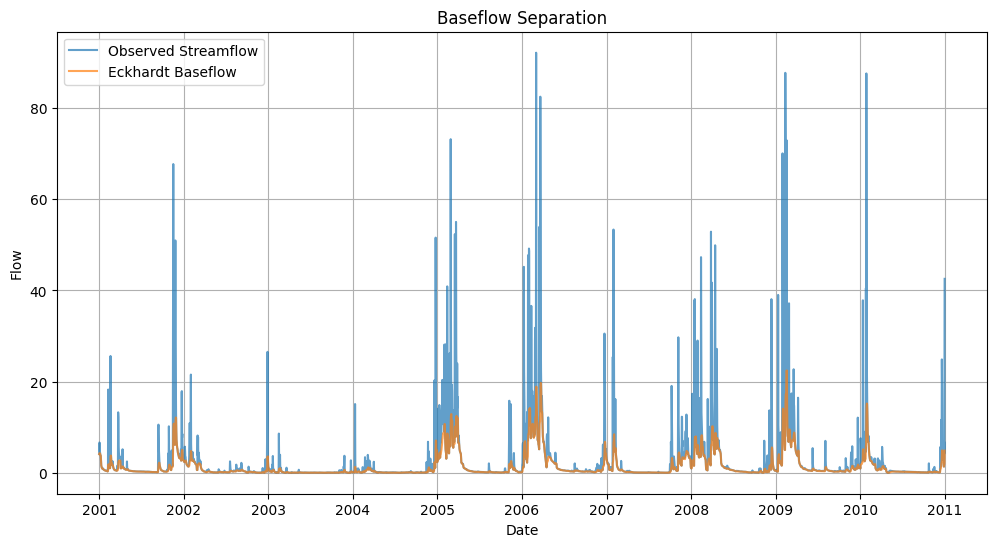

In [ ]:
plot_baseflow_separation(Q, bf_eckhardt, ['Eckhardt'], interactive=False)
plt.show()

### 2.6 EWMA
This technique applies an exponentially weighted moving average to the streamflow data, giving more weight to recent observations to estimate baseflow.

We provide four methods for calculating the initial baseflow value. Users are free to choose among these options. For more details, please refer to the help function.

In [ ]:
help(baseflow.separation.ewma)

Help on function ewma in module baseflow.separation:

ewma(Q, e, initial_method='Q0', return_exceed=False)
    exponential weighted moving average (EWMA) filter (Tularam & Ilahee, 2008)
    Tularam, Gurudeo Anand, and Mahbub Ilahee. “Exponential Smoothing Method of Base Flow Separation and Its Impact on Continuous Loss Estimates.” American Journal of Environmental Sciences 4, no. 2 (April 30, 2008): 136–44. https://doi.org/10.3844/ajessp.2008.136.144.
    
    Args:
        Q (np.array): streamflow
        e (float): smoothing parameter
        initial_method (str or float, optional): method to calculate the initial baseflow value.
            Accepted string values are:
            - 'Q0': Use Q[0] as the initial baseflow value.
            - 'min': Use np.min(Q) as the initial baseflow value.
            - 'LH': Calculate the initial baseflow value using the LH method.
            Alternatively, a float value can be provided to directly set the initial baseflow value.
            Def

In [ ]:
e = 0.2  # Assumed parameter e

bf_ewma = {
    'EWMA': baseflow.separation.ewma(Q.values, e, initial_method='Q0', return_exceed=False),
}


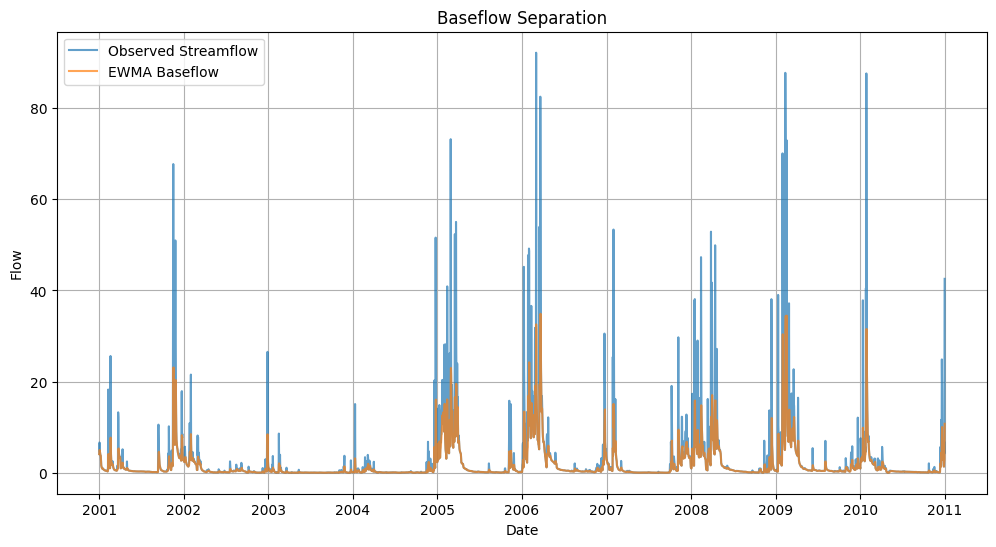

In [ ]:
plot_baseflow_separation(Q, bf_ewma, ['EWMA'], interactive=False)
plt.show()

### 2.7 Furey & Gupta
This hydrograph separation filter, introduced in 2001, is based on a mass balance equation for baseflow through a hillside, and its construction is founded on a physical-statistical theory of low streamflows developed by Furey and Gupta.

In [ ]:
help(baseflow.separation.furey)

Help on function furey in module baseflow.separation:

furey(Q, a, A, initial_method='Q0', return_exceed=False)
    Furey digital filter (Furey & Gupta, 2001, 2003)
    Furey, Peter R., and Vijay K. Gupta. “A Physically Based Filter for Separating Base Flow from Streamflow Time Series.” Water Resources Research 37, no. 11 (2001): 2709–22. https://doi.org/10.1029/2001WR000243.
    
    Args:
        Q (np.array): streamflow
        a (float): recession coefficient
        A (float): calibrated in baseflow.param_estimate
        initial_method (str or float, optional): method to calculate the initial baseflow value.
            Accepted string values are:
            - 'Q0': Use Q[0] as the initial baseflow value.
            - 'min': Use np.min(Q) as the initial baseflow value.
            - 'LH': Calculate the initial baseflow value using the LH method.
            Alternatively, a float value can be provided to directly set the initial baseflow value.
            Default is 'Q0'.
    

In [ ]:
a = 0.98  # Assumed recession coefficient
A = 0.1   # Assumed parameter A
bf_furey = {
    'Furey': baseflow.separation.furey(Q.values,a, A, initial_method='Q0', return_exceed=False),
}


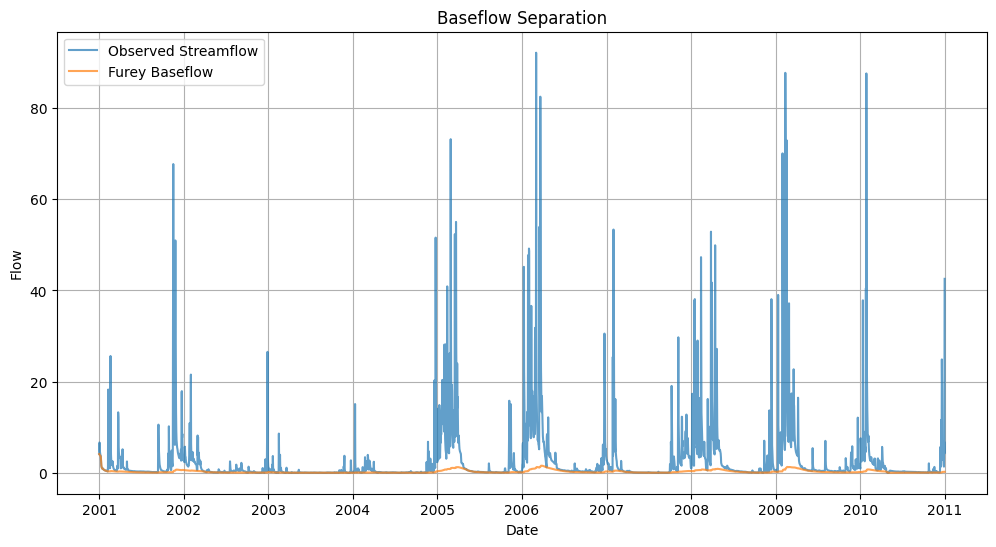

In [ ]:
plot_baseflow_separation(Q, bf_furey, ['Furey'], interactive=False)
plt.show()

### 2.8 HydroRun
This method involves using a digital filter approach to separate baseflow from total streamflow, often implemented in hydrological modeling software.

In [ ]:
help(baseflow.separation.hyd_run)

Help on function hyd_run in module baseflow.separation:

hyd_run(streamflow, k=0.9, passes=4)
    Separates baseflow from a streamflow hydrograph using a digital filter method.
    
    Args:
        streamflow (numpy.ndarray): A numpy array of streamflow values in chronological order.
        k (float, optional): A filter coefficient between 0 and 1 (typically 0.9). Defaults to 0.9.
        passes (int, optional): Number of times the filter passes through the data (typically 4). Defaults to 4.
    
    Returns:
        numpy.ndarray: A numpy array of baseflow values.
    
    Example:
        >>> import numpy as np
        >>> streamflow = np.array([10, 15, 20, 18, 12])
        >>> baseflow = hyd_run(streamflow)
        >>> print(baseflow)
        [10.         10.90909091 13.27272727 15.18181818 14.36363636]



In [ ]:
bf_hydrorun = {
    'HydroRun': baseflow.separation.hyd_run(Q.values,k=0.9, passes=4),
}

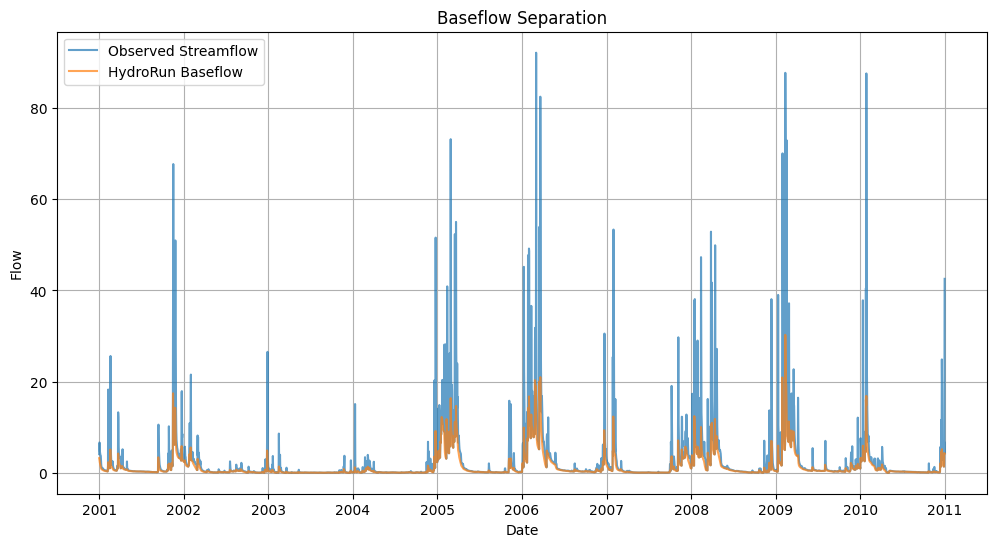

In [ ]:
plot_baseflow_separation(Q, bf_hydrorun, ['HydroRun'], interactive=False)
plt.show()

### 2.9 WHAT

WHAT (Web-based Hydrograph Analysis Tool) provides a web-based interface for hydrograph separation, using various algorithms to distinguish between baseflow and direct runoff.

In [ ]:
help(baseflow.separation.what)

Help on function what in module baseflow.separation:

what(streamflow, BFImax, alpha)
    Separates baseflow and quickflow from a streamflow time series using the WHAT method.
    
    Args:
        streamflow (numpy.ndarray): A numpy array of streamflow values.
        BFImax (float): The maximum baseflow index (BFI) value.
        alpha (float): A filter parameter.
    
    Returns:
        tuple: A tuple containing two numpy arrays: baseflow and quickflow.
    
    Example:
        >>> import numpy as np
        >>> streamflow = np.array([10, 15, 20, 18, 12])
        >>> baseflow, quickflow = what(streamflow, 0.8, 0.98)
        >>> print(baseflow)
        [ 9.8         12.74        15.68        16.544       15.3712    ]
        >>> print(quickflow)
        [ 0.2          2.26         4.32         1.456       -3.3712    ]



In [ ]:
BFImax = 0.8  # Assumed parameter BFImax
alpha = 0.925  # Assumed parameter alpha
bf_what = {
    'WHAT': baseflow.separation.what(Q.values, BFImax, alpha),
}

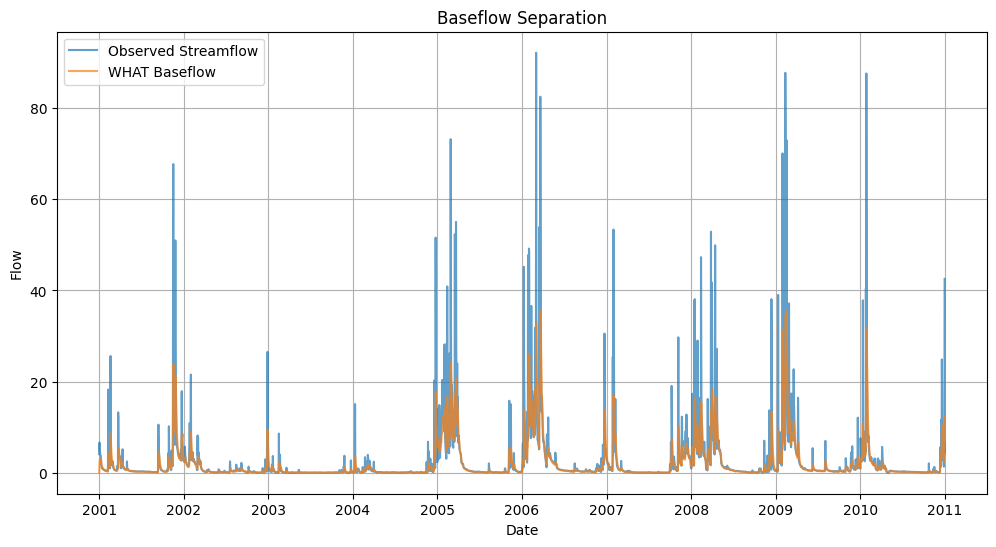

In [ ]:
plot_baseflow_separation(Q, bf_what, ['WHAT'], interactive=False)
plt.show()

### 2.10 Willems
This method uses a recursive digital filter to estimate baseflow, emphasizing the continuous adjustment of the filter parameters based on the flow conditions.

We provide four methods for calculating the initial baseflow value. Users are free to choose among these options. For more details, please refer to the help function.

In [ ]:
help(baseflow.separation.willems)

Help on function willems in module baseflow.separation:

willems(Q, a, w, initial_method='Q0', return_exceed=False)
    digital filter (Willems, 2009)
    
    Args:
        Q (np.array): streamflow
        a (float): recession coefficient
        w (float): case-speciﬁc average proportion of the quick ﬂow
                   in the streamflow, calibrated in baseflow.param_estimate
        initial_method (str or float, optional): method to calculate the initial baseflow value.
            Accepted string values are:
            - 'Q0': Use Q[0] as the initial baseflow value.
            - 'min': Use np.min(Q) as the initial baseflow value.
            - 'LH': Calculate the initial baseflow value using the LH method.
            Alternatively, a float value can be provided to directly set the initial baseflow value.
            Default is 'Q0'.
        return_exceed (bool, optional): if True, returns the number of times the
            baseflow exceeds the streamflow.



In [ ]:
a = 0.98  # Assumed recession coefficient
w = 0.1   # Assumed parameter w

bf_willems = {
    'Willems': baseflow.separation.willems(Q.values, a, w, initial_method='Q0', return_exceed=False),
}

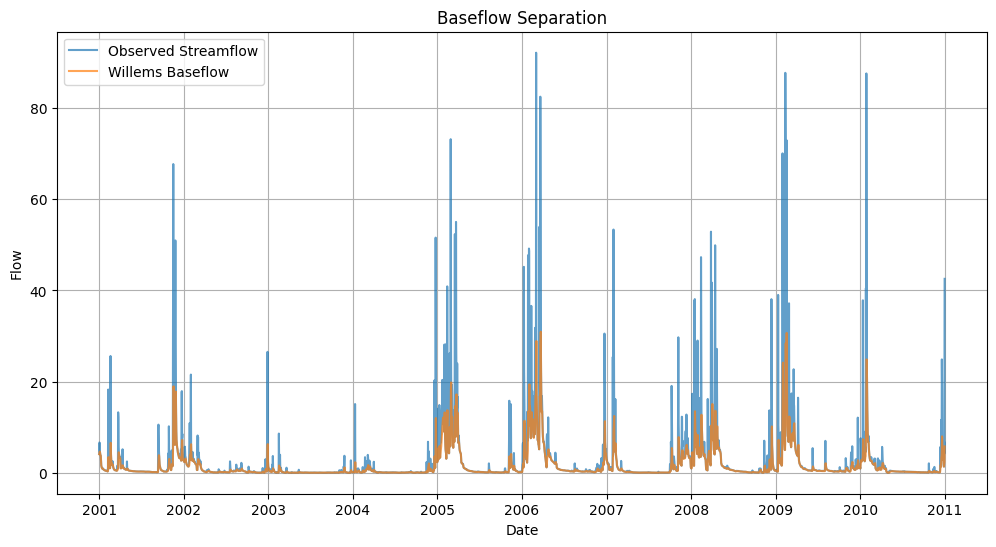

In [ ]:
plot_baseflow_separation(Q, bf_willems, ['Willems'], interactive=False)
plt.show()

### Compare the outcomes of all the methods

In [ ]:
baseflows = {
    'Fixed': bf_fixed['Fixed'],
    'Slide': bf_slide['Slide'],
    'Local': bf_local['Local'],
    'UKIH': bf_ukih['UKIH'],
    'Lyne Hollick': bf_lh['Lyne Hollick'],
    'Chapman': bf_chapman['Chapman'],
    'Chapman & Maxwell': bf_cm['Chapman & Maxwell'],
    'Boughton': bf_boughton['Boughton'],
    'Eckhardt': bf_eckhardt['Eckhardt'],
    'EWMA': bf_ewma['EWMA'],
    'Furey': bf_furey['Furey'],
    'HydroRun': bf_hydrorun['HydroRun'],
    'WHAT': bf_what['WHAT'],
    'Willems': bf_willems['Willems'],
}

fig = plot_baseflow_separation(Q, baseflows, ['Fixed', 'Slide', 'Local','UKIH', 'Lyne Hollick', 'Chapman', 'Chapman & Maxwell', 'Boughton', 'Eckhardt', 'EWMA', 'Furey', 'HydroRun', 'WHAT', 'Willems'], interactive=True)
fig.show()